In [1]:
from keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os

/home/vcubuntu2/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = load_model('models/unet.h5')

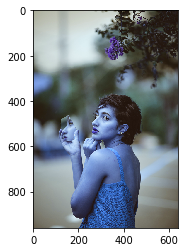

In [30]:
img = cv2.imread('imgs/02.png', cv2.IMREAD_COLOR)
img_ori = img.copy()

plt.imshow(img)

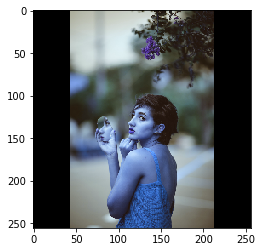

In [31]:
IMG_WIDTH, IMG_HEIGHT = 256, 256

def preprocess(img):
    im = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)

    if img.shape[0] >= img.shape[1]:
        scale = img.shape[0] / IMG_HEIGHT
        new_width = int(img.shape[1] / scale)
        diff = (IMG_WIDTH - new_width) // 2
        img = cv2.resize(img, (new_width, IMG_HEIGHT))

        im[:, diff:diff + new_width, :] = img
    else:
        scale = img.shape[1] / IMG_WIDTH
        new_height = int(img.shape[0] / scale)
        diff = (IMG_HEIGHT - new_height) // 2
        img = cv2.resize(img, (IMG_WIDTH, new_height))

        im[diff:diff + new_height, :, :] = img
        
    return im

img = preprocess(img)

plt.imshow(img)

In [32]:
pred = model.predict(img.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3)).astype(np.float32) / 255.)

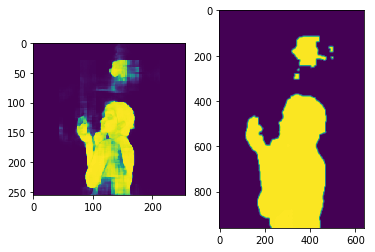

In [33]:
THRESHOLD = 0.3

def postprocess(img_ori, pred):
    h, w = img_ori.shape[:2]
    
    mask = (pred.squeeze()[:, :, 1] > THRESHOLD).astype(np.uint8)
    max_size = max(h, w)
    mask_ori = cv2.resize(mask, dsize=(max_size, max_size))

    if h >= w:
        diff = (max_size - w) // 2
        result_mask = mask_ori[:, diff:-diff]
    else:
        diff = (max_size - h) // 2
        result_mask = mask_ori[diff:-diff, :]
        
    result_mask = cv2.resize(result_mask, dsize=(w, h))
    
    # fill holes
    cv2.floodFill(result_mask, mask=np.zeros((h+2, w+2), np.uint8), seedPoint=(0, 0), newVal=255)
    result_mask = cv2.bitwise_not(result_mask)

    erosion_size = 3
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    result_mask = cv2.erode(result_mask, element)

    # blur edges
    result_mask = cv2.GaussianBlur(result_mask, ksize=(9, 9), sigmaX=5, sigmaY=5)
    
    return result_mask

mask = postprocess(img_ori, pred)

plt.subplot(1, 2, 1)
plt.imshow(pred[0, :, :, 1])
plt.subplot(1, 2, 2)
plt.imshow(mask)

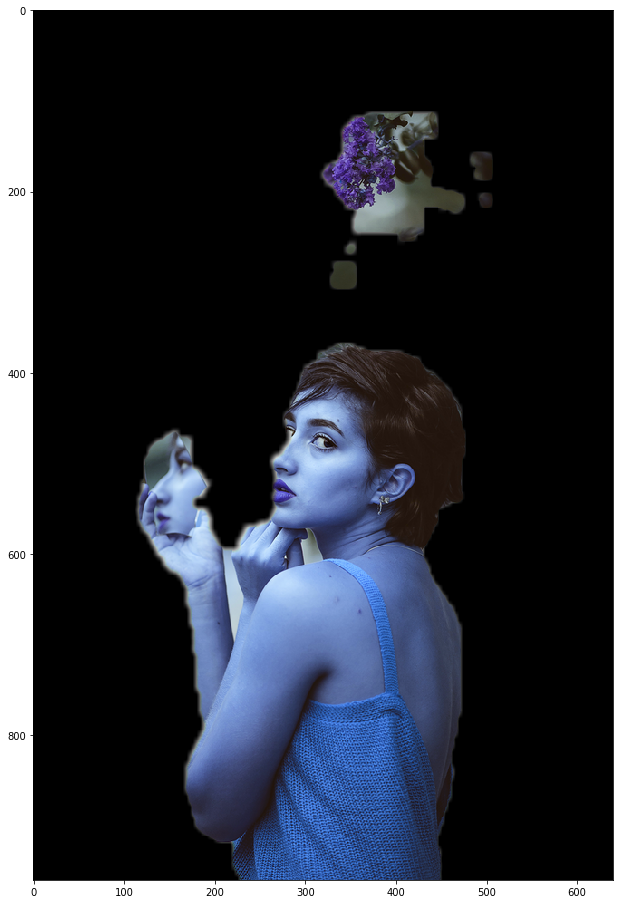

In [34]:
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

result_img = cv2.subtract(mask, img_ori)
result_img = cv2.subtract(mask, result_img)

plt.figure(figsize=(16, 16))
plt.imshow(result_img)